## 1. Import Libraries

In [1]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
import string
from pathlib import Path
from pprint import pprint

import gensim
from gensim import corpora

from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Set up NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Set the visualization style
sns.set(style="darkgrid")

# Initialize Stemmer and Lemmatizer
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kokji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kokji\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kokji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load Dataset

In [2]:
df=pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 3. Data Understanding

In [3]:
# Check the number of rows of data and for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
# Distribution of sentiments 
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [5]:
# Check for duplicates in 'review'
num_unique = df['review'].nunique()
print("Number of unique rows:", num_unique)
num_duplicates = df.duplicated(subset='review', keep=False).sum()
print("Number of duplicate rows:", num_duplicates)

Number of unique rows: 49582
Number of duplicate rows: 824


## 4. Data Cleaning

In [6]:
# Remove duplicates
df.drop_duplicates(subset='review', keep='first', inplace=True)
print(f'Dataset shape after removing duplicates: {df.shape}')

Dataset shape after removing duplicates: (49582, 2)


In [7]:
# Distribution of sentiments after data cleaning
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    24884
negative    24698
Name: count, dtype: int64


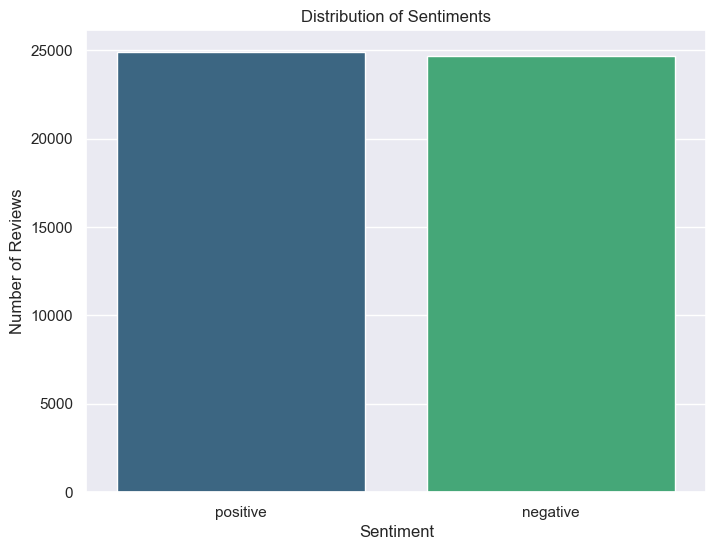

In [8]:
# Plot sentiment counts
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiments')
plt.show()

## 5. Data Pre-processing

In [9]:
# Define stopwords, punctuation, and initialize lemmatizer
stopwords_english = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [10]:
def clean(doc):
    # Convert to lowercase and tokenize
    words = word_tokenize(doc.lower())
    # Remove stopwords, non-alphabetic words, words less than 4 characters
    words = [word for word in words if word not in stopwords_english and word.isalpha() and len(word) > 4]
    # Remove punctuation
    words = [''.join([ch for ch in word if ch not in exclude]) for word in words]
    # Lemmatization
    words = [lemma.lemmatize(word) for word in words]
    # Join the words back into a single string 
    cleaned_doc = ' '.join(words)
    return cleaned_doc

doc_clean = [clean(doc).split() for doc in df['review']]

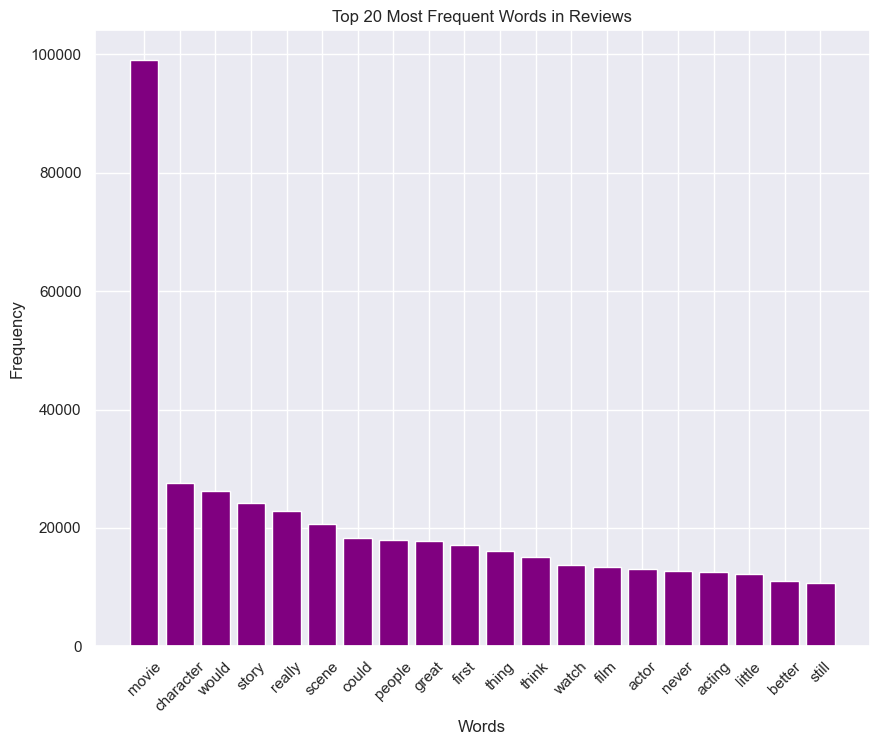

In [11]:
# Step 1: Flatten the list of words
all_words = [word for doc in doc_clean for word in doc]

# Step 2: Count the frequency of each word
word_freq = Counter(all_words)

# Step 3: Convert to Dataframe for easier plotting
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Step 4: Plot the top 20 most frequent words
plt.figure(figsize=(10,8))
plt.bar(word_freq_df['Word'][:20], word_freq_df['Frequency'][:20], color='purple')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words in Reviews')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Update stopwords to include 'movie'
stopwords_english.update(['movie'])

In [13]:
# Re-apply the clean function to the reviews
df['cleaned_review'] = df['review'].apply(clean)

## 6. Data Transformation

In [14]:
# Convert sentiment labels to binary values
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [15]:
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,1,reviewer mentioned watching episode hooked rig...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful spend summer weekend sitting...
3,Basically there's a family where a little boy ...,0,basically family little think zombie closet pa...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei money visually stunning watch ma...


## 7. Data Modelling and Training

In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

In [17]:
# Get English stopwords
stop_words = set(stopwords.words('english'))

# Convert stop_words to a list
stop_words_list = list(stop_words)

# Initialize the CountVectorizer to include both uni-grams and bi-grams
vectorizer = CountVectorizer(stop_words=stop_words_list, ngram_range=(1, 2), max_features=5000)

# Fit and transform the training data
X_train_vect = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_vect = vectorizer.transform(X_test)

# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_vect, y_train)

# Predict the sentiments for the test set
y_pred = nb_classifier.predict(X_test_vect)

## 8. Model Evaluation

Accuracy: 85.27%
              precision    recall  f1-score   support

    Negative       0.86      0.84      0.85      4939
    Positive       0.85      0.86      0.85      4978

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



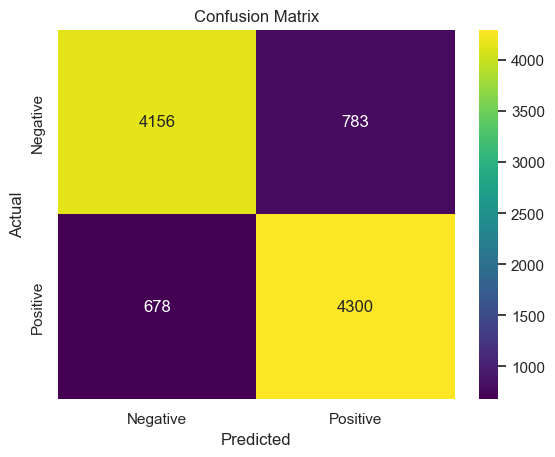

In [18]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display the classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 9. Deploying the Model on Unseen Data

In [19]:
# Function to clean and predict sentiment for a single review
def predict_sentiment(review, model, vectorizer):
    # Preprocess the review
    cleaned_review = clean(review)
    
    # Convert the cleaned review to a vector
    review_vect = vectorizer.transform([cleaned_review])
    
    # Predict sentiment
    prediction = model.predict(review_vect)
    
    # Return the sentiment
    return 'Positive' if prediction[0] == 1 else 'Negative'

# Function to read a review from a file, predict its sentiment, and insert the sentiment into the file
def insert_sentiment_into_file(file_path, model, vectorizer):
    # Try using a different encoding if 'utf-8' fails
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='ISO-8859-1')

    # Predict sentiment for each review
    df['Sentiment'] = df['review'].apply(lambda review: predict_sentiment(review, model, vectorizer))

    # Save the updated DataFrame back to the file
    df.to_csv(file_path, index=False, encoding='utf-8')
    print()
    print(f'Sentiments have been added to the file: {file_path}')

In [ ]:
# Deploying the Model
file_path = input("Please enter the path to your movie review file: ")
insert_sentiment_into_file(file_path, nb_classifier, vectorizer)